In [2]:
import time
import numpy as np
import networkx as nx
from utils.dotdict import dotdict
import matplotlib.pyplot as plt
from numba import jit

import itertools
import multiprocessing

from utils.graph_generator import get_graph

from scripts.awareness.agent_country import Agent_Country

In [3]:
args = dotdict({
    "logfile": "log/temp.log",
    "plot": False,
    "max_iteration": 1000,
    "beta_super":0.0,
    "xi": 1,
    "p_teleport":0.0,
    "MAX_E_TIME":10,
    "MAX_I_TIME":10,
    "super_infected_agents": [],
    "p_super": 0.0,
    "awM": None,
    "awR": -1,
    "random_seed":0,
    "CPU_cores":15,
    "simnum":10,
})


In [4]:

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def pos_in_rectangle(pos, rect):
    return pos[0]>=rect[0] and pos[0]<=rect[1] and pos[1]>=rect[2] and pos[1]<=rect[3]

def get_diam(country, graph):
    Is = np.arange(len(graph))[country.states==2]
    #print(Is, graph.nodes)
    Is = [n for i,n in enumerate(graph.nodes) if country.states[i]==2]
    g = graph.subgraph(Is)
    
    nodes = sorted(nx.connected_components(g), key=len, reverse=True)[0]
    g = g.subgraph(nodes)

    ps = np.array(list(nx.get_node_attributes(g, 'pos').values()))
    #print(ps, ps.shape)
    pos = nx.get_node_attributes(graph, 'pos')
    rect = [np.min(ps[:,0]), np.max(ps[:,0]), np.min(ps[:,1]), np.max(ps[:,1])]
    Inf_rect = [n for i,n in enumerate(graph.nodes) if country.states[i]==2 and pos_in_rectangle(pos[n],rect)]
    
    #return np.array([nx.diameter(g), len(nodes), len(Inf_rect)/((rect[1]-rect[0]+1)*(rect[3]-rect[2]+1))])
    return np.array([nx.diameter(g), len(nodes), len(nodes)/((rect[1]-rect[0]+1)*(rect[3]-rect[2]+1))])

def run(args, beta, gamma, n, awM, random_seed=0):
    args = dotdict(args)
    graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
    args["I_time"]=int(1/gamma)
    args["infected_agents"]=[n//2+(n//2)*n]
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM


    res = np.zeros(shape=(args["max_iteration"], 4))
    diams = np.zeros(shape=(args["max_iteration"], 3))

    country = Agent_Country(args, graph)
    country.init_seeds = args["infected_agents"]
    Agent_Country.numba_random_seed(random_seed)
    country.log_json()
    for i in range(args["max_iteration"]):
        res[i,2]=np.sum(country.states ==2)
        diams[i,:] = get_diam(country, graph)
        if country.check_stop():
            #break
            pass
        country.step()
        country.log_json()

    return res[:i,2], diams[:i]

# Diameter and Total infected agents in the awareness model

* ==> There is an interval, where these two values vary

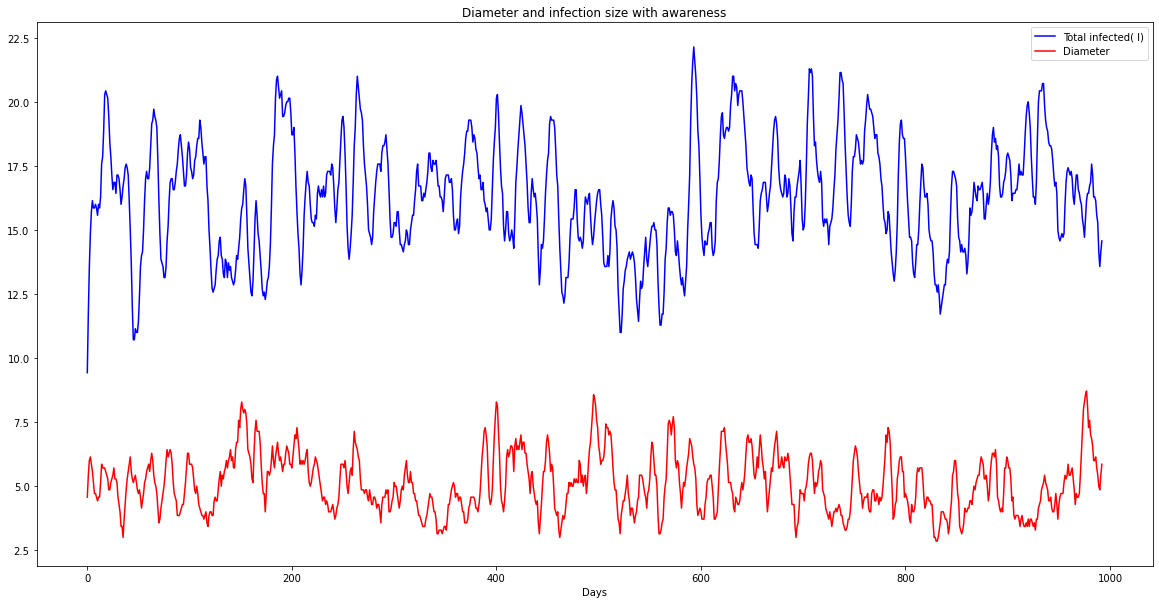

In [106]:
res,diams = run(args, 0.6, 0.55, 30, 0.1)

plt.figure(figsize=(20,10))

plt.plot(moving_average(res,7), c='b', label="Total infected( I)")
plt.plot(moving_average(diams[:,0],7), label="Diameter", c="r")
#plt.plot(moving_average(diams[:,1],7), label="Largest comp", c="g")
#plt.plot(moving_average(diams[:,2],7), label="Density", c="y")

plt.legend()
plt.xlabel("Days")
plt.title("Diameter and infection size with awareness")
plt.show()

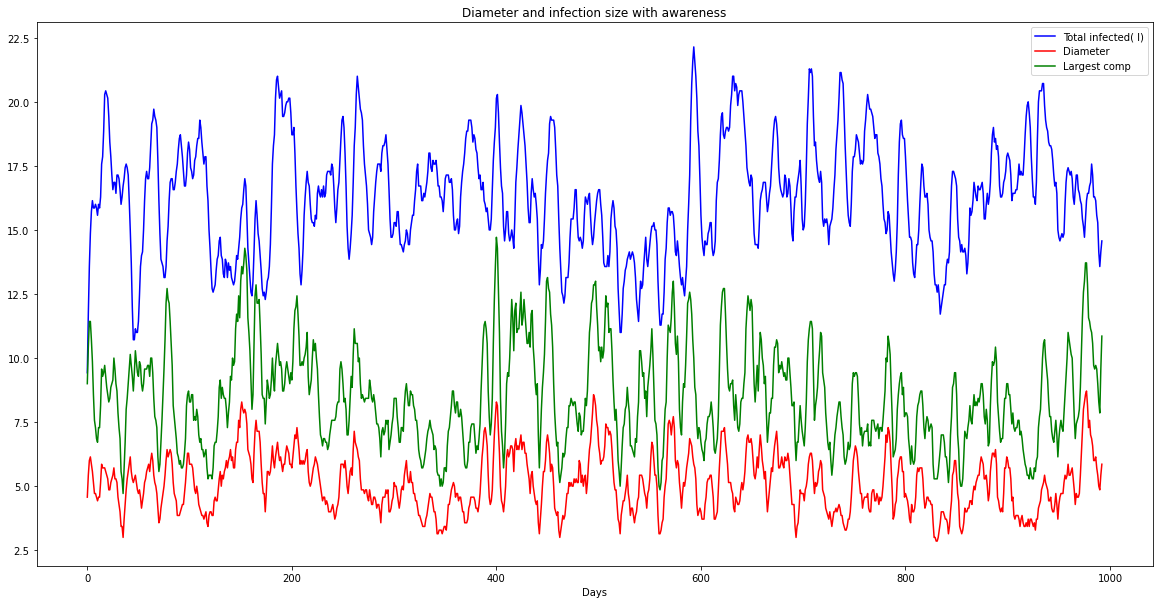

In [107]:
plt.figure(figsize=(20,10))

plt.plot(moving_average(res,7), c='b', label="Total infected( I)")
plt.plot(moving_average(diams[:,0],7), label="Diameter", c="r")
plt.plot(moving_average(diams[:,1],7), label="Largest comp", c="g")
#plt.plot(moving_average(diams[:,2],7), label="Density", c="y")

plt.legend()
plt.xlabel("Days")
plt.title("Diameter and infection size with awareness")
plt.show()

### This typical size does not depend on the size of the grid (if $n>>N_0$)

In [5]:
%%time

ns = [20,30,40,50,60]
iters = 2

Is = np.zeros(shape=(len(ns),iters, 2))
ds = np.zeros(shape=(len(ns),iters, 2))

for n_i,n in enumerate(ns):
    for i in range(iters):
        print("\r {}".format(n), end='   ', flush=True)
        I,diam = run(args, 0.6, 0.3, n, 0.1, i)

        Is[n_i,i, 0] = np.mean(I[args["max_iteration"]//2:])
        Is[n_i,i, 1] = np.std(I[args["max_iteration"]//2:])
        ds[n_i, i, 0] = np.mean(diam[args["max_iteration"]//2:,0])
        ds[n_i, i, 1] = np.std(diam[args["max_iteration"]//2:,0])

 50   CPU times: user 3min 13s, sys: 1.34 s, total: 3min 15s
Wall time: 3min 15s


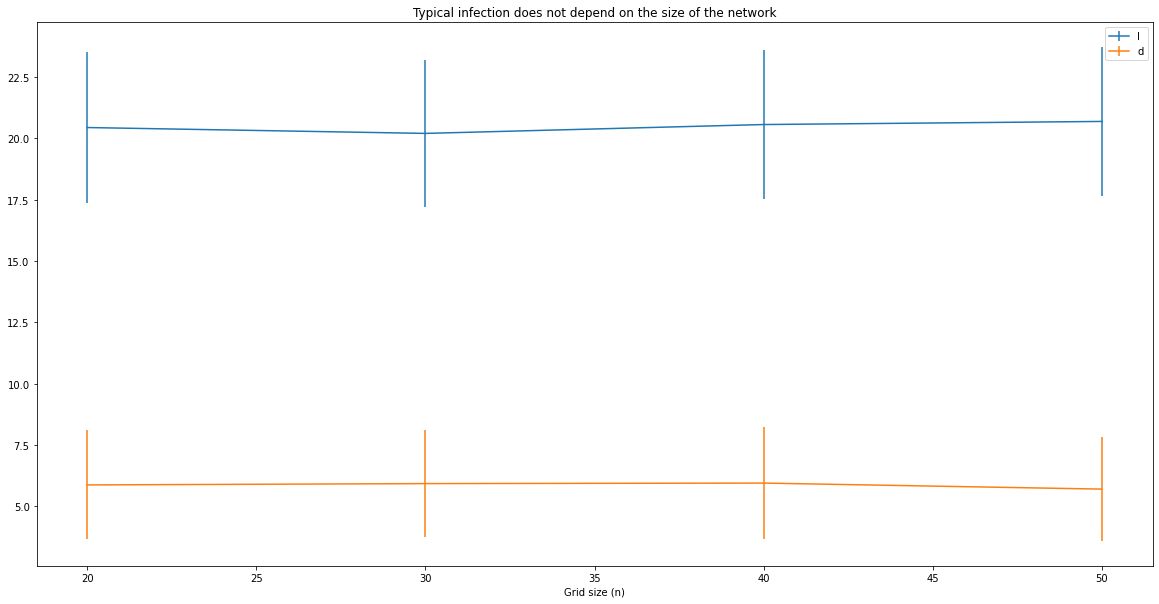

In [7]:
plt.figure(figsize=(20,10))

plt.errorbar(ns, np.mean(Is, axis=1)[:,0], yerr=np.mean(Is, axis=1)[:,1], label="I")
plt.errorbar(ns, np.mean(ds, axis=1)[:,0], yerr=np.mean(ds, axis=1)[:,1], label="d")
plt.xlabel("Grid size (n)")

plt.legend()
plt.title("Typical infection does not depend on the size of the network")
#plt.yscale("log")
plt.show()

# Diameter dependency of the Global awareness parameter (m)

In [117]:
%%time

ms = np.linspace(0.01,0.2, 10)
iters = 2

Is = np.zeros(shape=(len(ms),iters, 2))
ds = np.zeros(shape=(len(ms),iters, 2))

for m_i,m in enumerate(ms):
    for i in range(iters):
        print("\r {}".format(m), end='   ', flush=True)
        I,diam = run(args, 0.6, 0.3, 30, m, i)

        Is[m_i,i, 0] = np.mean(I[args["max_iteration"]//2:])
        Is[m_i,i, 1] = np.std(I[args["max_iteration"]//2:])
        ds[m_i, i, 0] = np.mean(diam[args["max_iteration"]//2:,0])
        ds[m_i, i, 1] = np.std(diam[args["max_iteration"]//2:,0])

 0.2   888888888889     CPU times: user 4min 7s, sys: 2.04 s, total: 4min 9s
Wall time: 4min 9s


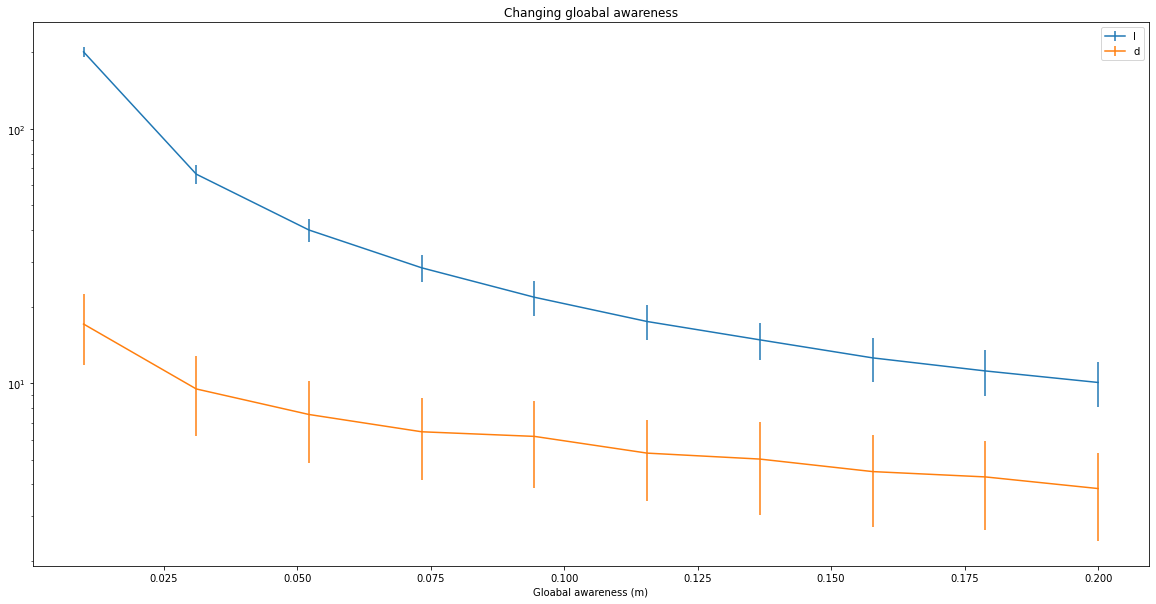

In [118]:
plt.figure(figsize=(20,10))

plt.errorbar(ms, np.mean(Is, axis=1)[:,0], yerr=np.mean(Is, axis=1)[:,1], label="I")
plt.errorbar(ms, np.mean(ds, axis=1)[:,0], yerr=np.mean(ds, axis=1)[:,1], label="d")
plt.xlabel("Gloabal awareness (m)")

plt.legend()
plt.title("Changing gloabal awareness")
plt.yscale("log")
plt.show()

In [8]:
%%time

betas = np.linspace(0.35,0.8, 10)
iters = 2

Is = np.zeros(shape=(len(betas),iters, 2))
ds = np.zeros(shape=(len(betas),iters, 2))

for b_i,beta in enumerate(betas):
    for i in range(iters):
        print("\r {}".format(beta), end='   ', flush=True)
        I,diam = run(args, beta, 0.3, 30, 0.1, i)

        Is[b_i,i, 0] = np.mean(I[args["max_iteration"]//2:])
        Is[b_i,i, 1] = np.std(I[args["max_iteration"]//2:])
        ds[b_i, i, 0] = np.mean(diam[args["max_iteration"]//2:,0])
        ds[b_i, i, 1] = np.std(diam[args["max_iteration"]//2:,0])

 0.8    00000000001    CPU times: user 5min 24s, sys: 2.19 s, total: 5min 27s
Wall time: 5min 27s


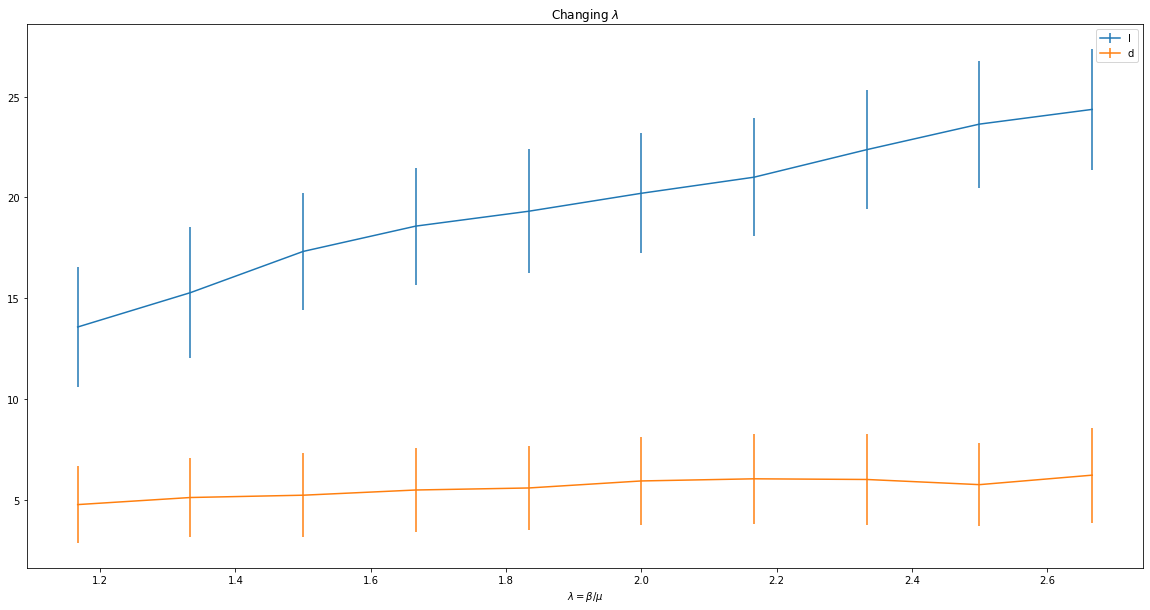

In [9]:
plt.figure(figsize=(20,10))

plt.errorbar(betas/0.3, np.mean(Is, axis=1)[:,0], yerr=np.mean(Is, axis=1)[:,1], label="I")
plt.errorbar(betas/0.3, np.mean(ds, axis=1)[:,0], yerr=np.mean(ds, axis=1)[:,1], label="d")
plt.xlabel(r"$\lambda = \beta/\mu$")

plt.legend()
plt.title(r"Changing $\lambda$")
#plt.yscale("log")
plt.show()

In [10]:
Is, ds;

# Density of the largest component

* we measure the density of the smallest rectangle, which contains the largest component

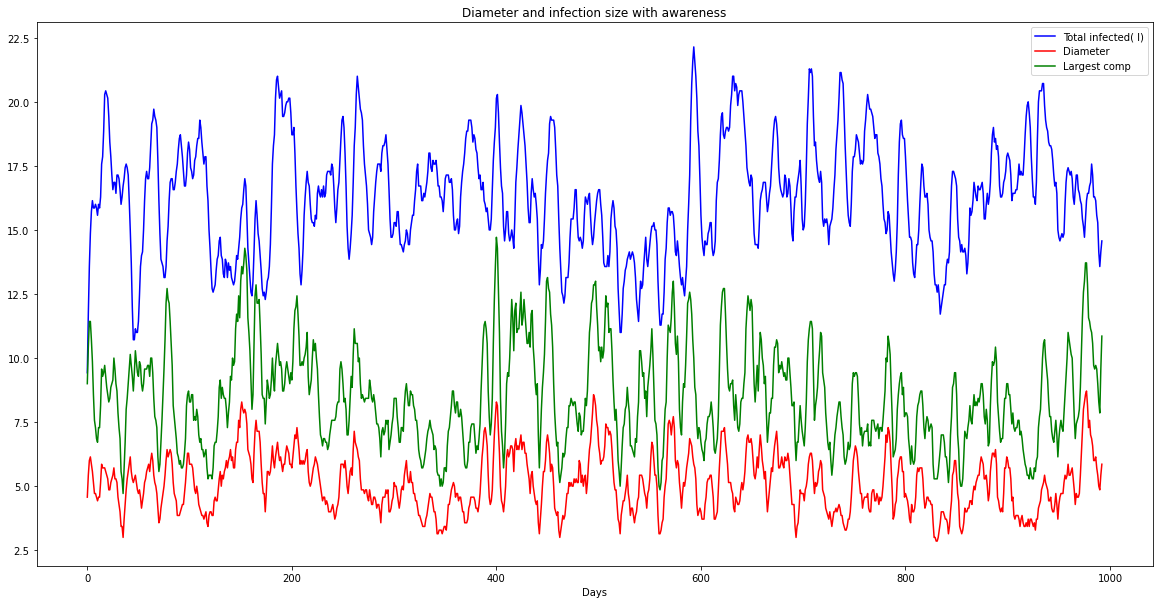

In [86]:
res,diams = run(args, 0.6, 0.55, 30, 0.1)

plt.figure(figsize=(20,10))

plt.plot(moving_average(res,7), c='b', label="Total infected( I)")
plt.plot(moving_average(diams[:,0],7), label="Diameter", c="r")
#plt.plot(moving_average(diams[:,1],7), label="Largest comp", c="g")
ax = plt.gca()
ax.plot(moving_average(diams[:,2],7), label="Density", c="y")

plt.legend()
plt.xlabel("Days")
plt.title("Diameter and infection size with awareness")
plt.show()

## Changing gloabal awareness (m)

In [11]:
%%time

ms = np.linspace(0.01,0.2, 10)
iters = 2

Is = np.zeros(shape=(len(ms),iters, 2))
ds = np.zeros(shape=(len(ms),iters, 2))

for m_i,m in enumerate(ms):
    for i in range(iters):
        print("\r {}".format(m), end='   ', flush=True)
        I,diam = run(args, 0.6, 0.3, 30, m, i)

        Is[m_i,i, 0] = np.mean(I[args["max_iteration"]//2:])
        Is[m_i,i, 1] = np.std(I[args["max_iteration"]//2:])
        ds[m_i, i, 0] = np.mean(diam[args["max_iteration"]//2:,2])
        ds[m_i, i, 1] = np.std(diam[args["max_iteration"]//2:,2])

 0.2   888888888889     CPU times: user 5min 55s, sys: 2.1 s, total: 5min 57s
Wall time: 5min 57s


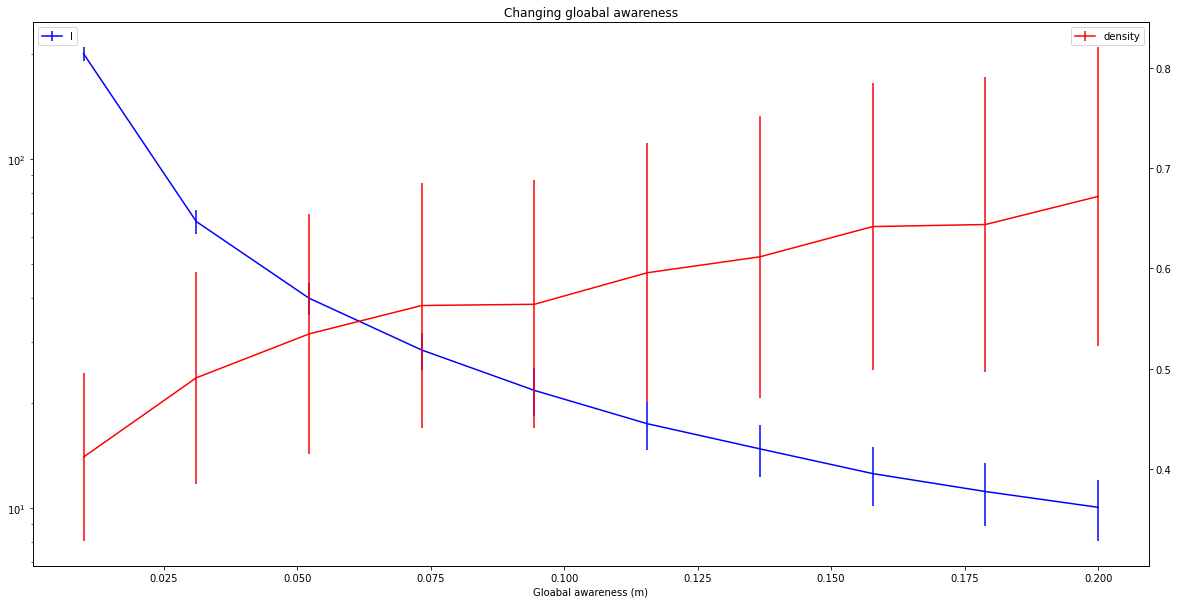

In [34]:
plt.figure(figsize=(20,10))

ax0 = plt.gca()
ax0.errorbar(ms, np.mean(Is, axis=1)[:,0], yerr=np.mean(Is, axis=1)[:,1], label="I", c="b")
ax0.set_yscale("log")



ax1 = ax0.twinx()
ax1.errorbar(ms, np.mean(ds, axis=1)[:,0], yerr=np.mean(ds, axis=1)[:,1], label="density", c="r")

ax0.legend(loc=2)
ax1.legend(loc=0)

ax0.set_xlabel("Gloabal awareness (m)")
plt.title("Changing gloabal awareness")
plt.show()

# Changing $\lambda=\frac{\beta}{\mu}$

In [7]:
%%time

betas = np.linspace(0.35,0.8, 10)
iters = 2

Is = np.zeros(shape=(len(betas),iters, 2))
ds = np.zeros(shape=(len(betas),iters, 2))

for b_i,beta in enumerate(betas):
    for i in range(iters):
        print("\r {}".format(beta), end='   ', flush=True)
        I,diam = run(args, beta, 0.3, 30, 0.1, i)

        Is[b_i,i, 0] = np.mean(I[args["max_iteration"]//2:])
        Is[b_i,i, 1] = np.std(I[args["max_iteration"]//2:])
        ds[b_i, i, 0] = np.mean(diam[args["max_iteration"]//2:,2])
        ds[b_i, i, 1] = np.std(diam[args["max_iteration"]//2:,2])

 0.8    00000000001    CPU times: user 5min 54s, sys: 2.68 s, total: 5min 57s
Wall time: 6min 3s


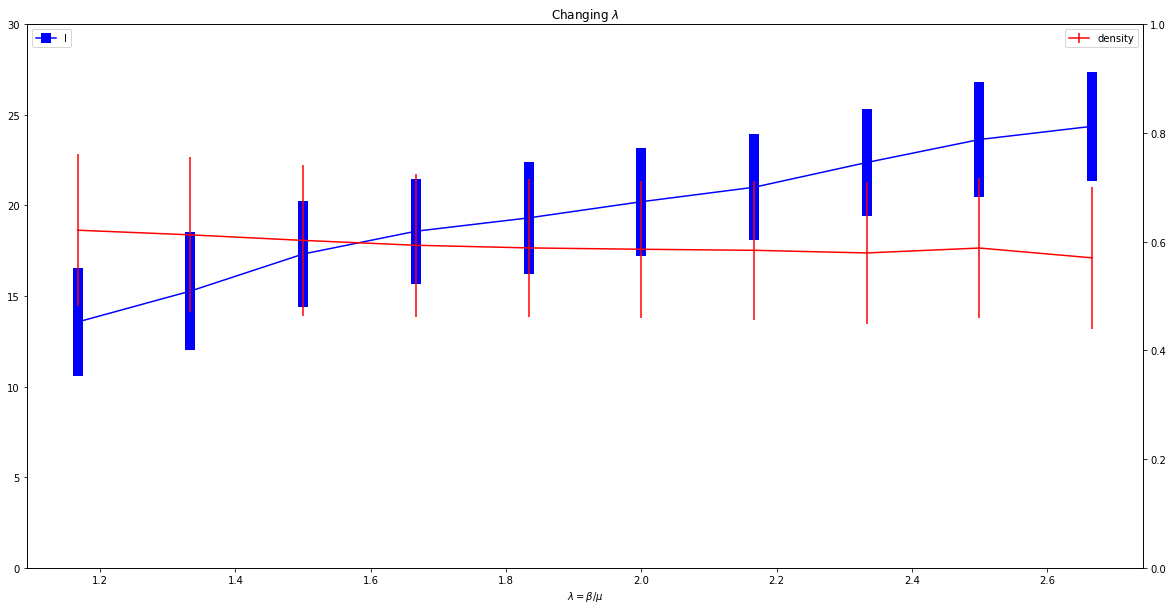

In [8]:
plt.figure(figsize=(20,10))

ax0 = plt.gca()
ax0.errorbar(betas/0.3, np.mean(Is, axis=1)[:,0], yerr=np.mean(Is, axis=1)[:,1], label="I", c="b", elinewidth=10)
ax0.set_ylim([0,30])
#ax0.set_yscale("log")



ax1 = ax0.twinx()
ax1.errorbar(betas/0.3, np.mean(ds, axis=1)[:,0], yerr=np.mean(ds, axis=1)[:,1], label="density", c="r")
ax1.set_ylim([0,1])
ax0.legend(loc=2)
ax1.legend(loc=0)

ax0.set_xlabel(r"$\lambda = \beta/\mu$")
plt.title(r"Changing $\lambda$")
plt.show()

# Temp

In [ ]:
res,diams = run(args, 0.6, 0.55, 30, 0.1)

plt.figure(figsize=(20,10))

plt.plot(moving_average(res,7), c='b', label="Total infected( I)")
plt.plot(moving_average(diams[:,0],7), label="Diameter", c="r")
#plt.plot(moving_average(diams[:,1],7), label="Largest comp", c="g")
#plt.plot(moving_average(diams[:,2],7), label="Density", c="y")

plt.legend()
plt.xlabel("Days")
plt.title("Diameter and infection size with awareness")
plt.show()